# Simulate Independent Trajectories

This notebook examines the solutions of the revised model presented in "The 2010 structural-demographic forecast for the 2010–2020 decade: A retrospective assessment". 

## Simulation Logic

For each parameter in the simulation, we draw a random sample from a Gaussian distribution. The covariance matrix for the inputs is assumed to be diagonal, with a mean around the paper's parameters and a standard deviation of 10% of this value. We solve the dynamical system forward in time for each sample an examine the range of solutions.

In [12]:
import numpy as np

from typing import List, Tuple
from cliodynamics.system.sdt import RetrospectiveSDTModel

def simulate_trajectories(
    initial_conditions: List[float],
    time_span: Tuple[float, float],
    time_points: np.ndarray,
    base_model: RetrospectiveSDTModel,
    n_trajectories: int = 100,
    method: str = "RK45"
) -> np.ndarray:
    """
    Simulates N trajectories by sampling model parameters from a normal distribution with 
    10% standard deviation around the baseline rates, truncated at [0, 1].

    Parameters
    ----------
    initial_conditions : list of float
        Initial values for the system variables.
    time_span : tuple of float
        Start and end time for the integration.
    time_points : numpy.ndarray
        Array of time points where solution is evaluated.
    base_model : RetrospectiveSDTModel
        The model with the canonical parameters.
    n_trajectories : int
        The number of trajectories to generate.

    Returns
    -------
    trajectories : np.ndarray
        Array of shape (n_trajectories, time_points, variables) containing the trajectories.
    """
    trajectories = np.zeros((n_trajectories, len(base_model.time_points), 4))

    for i in range(n_trajectories):
        # Sample each rate with a 10% standard deviation and truncate to [0, 1]
        birth_rate = np.clip(np.random.normal(base_model.birth_rate, 0.1 * base_model.birth_rate), 0, 1)
        death_rate = np.clip(np.random.normal(base_model.death_rate, 0.1 * base_model.death_rate), 0, 1)
        elite_overproduction_rate = np.clip(np.random.normal(base_model.elite_overproduction_rate, 0.1 * base_model.elite_overproduction_rate), 0, 1)
        economic_inequality_rate = np.clip(np.random.normal(base_model.economic_inequality_rate, 0.1 * base_model.economic_inequality_rate), 0, 1)
        socio_political_stress_rate = np.clip(np.random.normal(base_model.socio_political_stress_rate, 0.1 * base_model.socio_political_stress_rate), 0, 1)

        model = RetrospectiveSDTModel(
            initial_conditions=initial_conditions,
            time_span=time_span,
            time_points=time_points,
            birth_rate=birth_rate,
            death_rate=death_rate,
            elite_overproduction_rate=elite_overproduction_rate,
            economic_inequality_rate=economic_inequality_rate,
            socio_political_stress_rate=socio_political_stress_rate
        )
        # Solve the model with the sampled parameters
        solution = model.solve(method=method)
        
        # Store the solution for each time point
        trajectories[i] = solution.y.T

    return trajectories

## Uncertainty Contour Plot

Visual for the uncertainty contours.

In [17]:
import matplotlib.pylab as plt

def plot_uncertainty_contours(time_points: np.ndarray, trajectories: np.ndarray):
    """
    Plots the uncertainty contours based on multiple simulated trajectories.

    Parameters
    ----------
    time_points : np.ndarray
        The time grid that the trajectories were sovled on
    trajectories : np.ndarray
        The simulated trajectories

    """
    # Compute median and 95% confidence interval
    median_values = np.median(trajectories, axis=0)
    lower_bound = np.percentile(trajectories, 2.5, axis=0)
    upper_bound = np.percentile(trajectories, 97.5, axis=0)

    # Plotting
    variables = ['Population', 'Economic Inequality', 'Elite Population', 'Socio-Political Stress']
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        ax.plot(time_points, median_values[:, i], color='blue', label='Median Trajectory')
        ax.fill_between(time_points, lower_bound[:, i], upper_bound[:, i], color='lightblue', alpha=0.4, label='95% Confidence Interval')
        ax.set_title(variables[i])
        ax.set_xlabel("Time (years)")
        ax.set_ylabel(variables[i])
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.suptitle('Uncertainty Contours for Structural-Demographic Model', y=1.02)
    plt.show()

## Run Simulations

Populate a set of solutions.

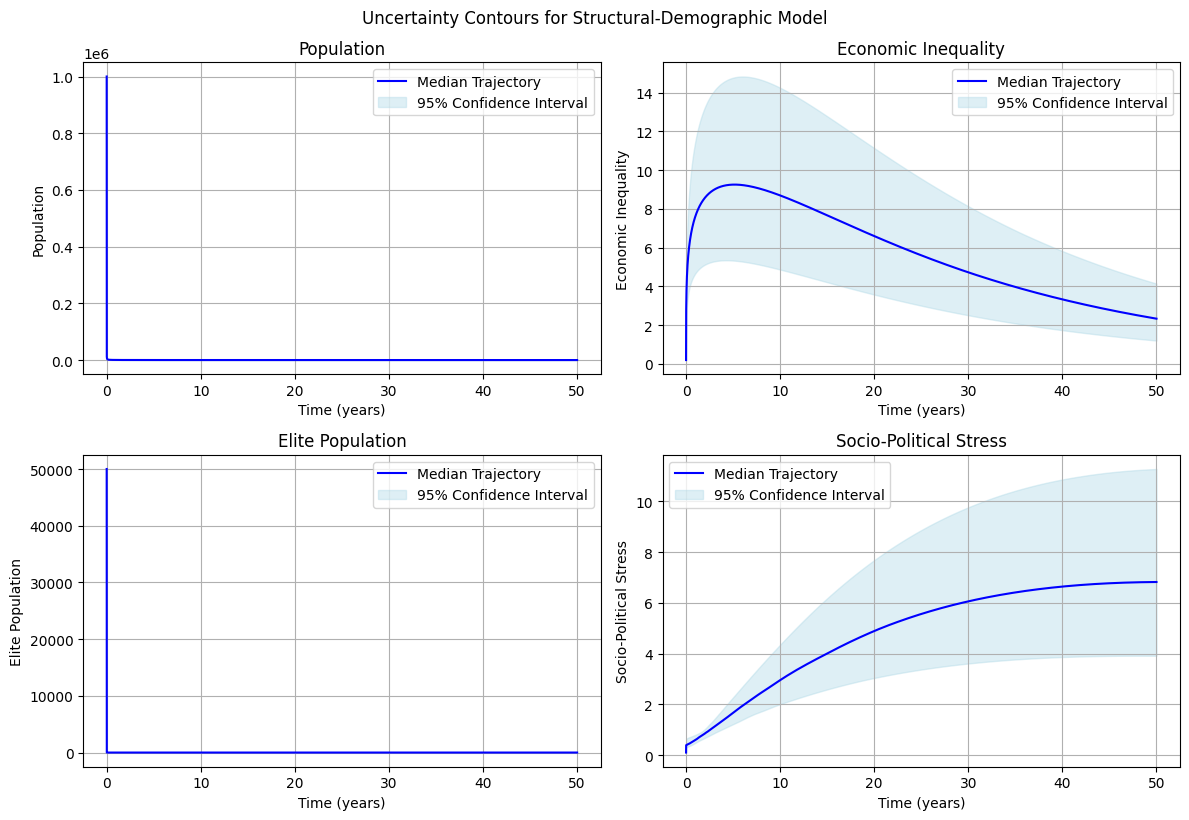

In [37]:
# Set seed
np.random.seed(1)

# Define the baseline parameters as provided in the paper
initial_conditions = [1.0e6, 0.2, 50000, 0.1]  # Initial conditions: [Population, Economic Inequality, Elite Population, Socio-Political Stress]
time_span = (0, 50)  # Time range for the model
time_points = np.linspace(*time_span, 20000)  # Discretized time points

canonical_model = RetrospectiveSDTModel(
    initial_conditions=initial_conditions,
    time_span=time_span,
    time_points=time_points,
    birth_rate=0.02,
    death_rate=0.015,
    elite_overproduction_rate=0.01,
    economic_inequality_rate=0.005,
    socio_political_stress_rate=0.03
)

# Plot the uncertainty contours based on 100 simulated trajectories
trajectories = simulate_trajectories(initial_conditions, time_span, time_points, canonical_model, n_trajectories=100, method="BDF")
plot_uncertainty_contours(time_points, trajectories)